<a href="https://colab.research.google.com/github/louiezzang/next-diffusion/blob/main/examples/texutal_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textual Inversion Fine-tuning


## Initial setup

In [1]:
#@title Install next-diffusion lib
!rm -rf ./next-diffusion/
!git clone https://github.com/louiezzang/next-diffusion.git
# %cd next-diffusion/
# !pip install .
# %cd ../

Cloning into 'next-diffusion'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 149 (delta 63), reused 106 (delta 34), pack-reused 0
Receiving objects: 100% (149/149), 7.43 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
# !pip install -U -qq diffusers==0.14.0
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00


In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F

import PIL
from diffusers import StableDiffusionPipeline
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [4]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

### Get the training images:

#### Download the images from the internet and save them locally.

You can also upload the images to colab or load from google drive, please check the next section if you want to use that.

In [5]:
#@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
urls = [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

In [6]:
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None, [download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

[None, None, None, None]

#### Load images from local folder

You can also load your own training images from google drive or upload them to colab usingthe files taband then provide the path to the directory containing images. 

*Make sure that the directory only contains images as the following cells will read all the files from the provided directory.*

In [7]:
#@markdown `images_path` is a path to directory containing the training images. It could 
images_path = "./my_concept/" #@param {type:"string"}
while not os.path.exists(str(images_path)):
  print('The images_path specified does not exist, use the colab file explorer to copy the path :')
  images_path=input("")
save_path = images_path

####  Setup and check the images you have just added

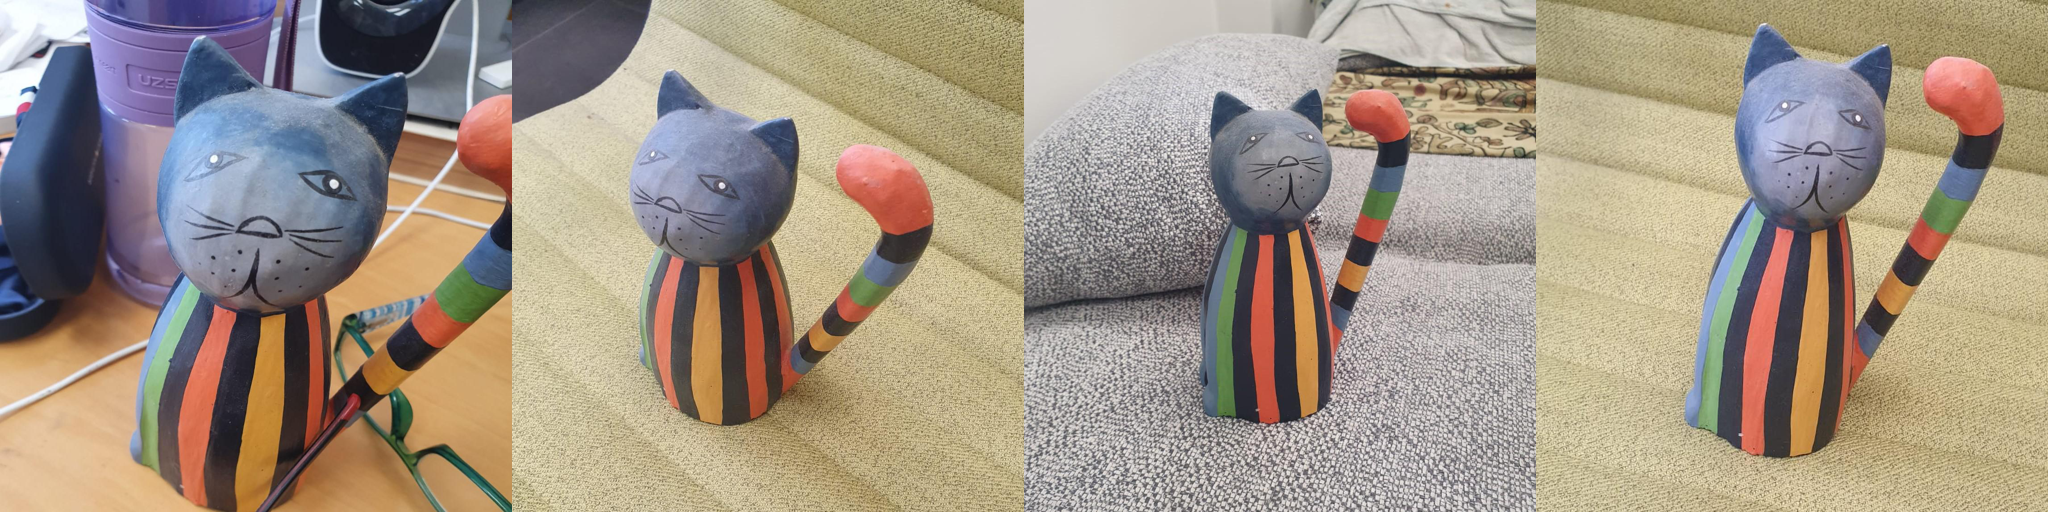

In [8]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [8]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<cat-toy>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "toy" #@param {type:"string"}

## Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Training

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [9]:
#@title Setting up accelerator config for the notebook environment.
from accelerate.utils import write_basic_config
write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [10]:
output_dir = "textual_inversion_cat"
!mkdir -p textual_inversion_cat

In [11]:
os.environ["MODEL_NAME"] = pretrained_model_name_or_path
os.environ["DATA_DIR"] = save_path
os.environ["LEARNABLE_PROPERTY"] = what_to_teach
os.environ["PLACEHOLDER_TOKEN"] = placeholder_token
os.environ["INITIALIZER_TOKEN"] = initializer_token
os.environ["OUTPUT_DIR"] = output_dir

___Note: Change the resolution to 768 if you are using the stable-diffusion-2 768x768 model.___

In [22]:
!accelerate launch ./next-diffusion/scripts/textual_inversion/textual_inversion.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$DATA_DIR \
  --learnable_property=$LEARNABLE_PROPERTY \
  --placeholder_token=$PLACEHOLDER_TOKEN \
  --initializer_token=$INITIALIZER_TOKEN \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=3000 \
  --learning_rate=5.0e-04 --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --output_dir=$OUTPUT_DIR \
  --save_as_full_pipeline

2023-05-11 18:33:50.449876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-11 18:33:54.941651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/11/2023 18:33:57 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'dynamic_thresholding_ratio', 'clip_sample_range', 'sample_max_value', 'thresholding', 'variance_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'addition_embed_type', 'conv_in_kernel', 'conv_out_kernel', 'resnet_skip_time_act', 'mid_block_only_cross

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it

To save this concept for re-using, download the `learned_embeds.bin` file or save it on the library of concepts.

Use the [Stable Conceptualizer notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) for inference with persistently saved pre-trained concepts

In [23]:
#@title Set up the pipeline 
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    output_dir,
    scheduler=DPMSolverMultistepScheduler.from_pretrained(output_dir, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

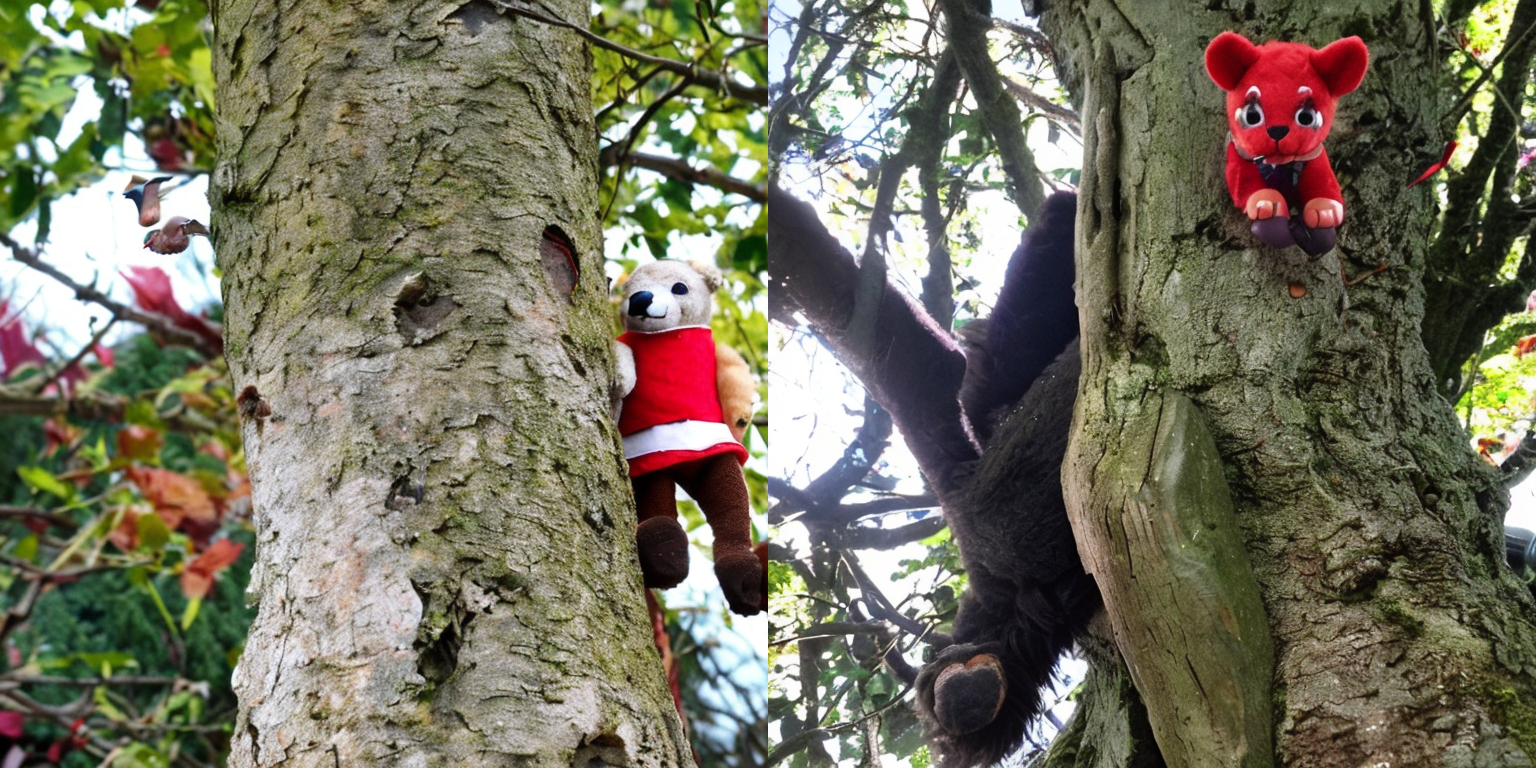

In [24]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a \u003Ccat-toy> in the tree" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid